# HeadDiffLineSink1D and FluxDiffLineSink1D

Continuity of head and continuity of flow.

In [36]:
import matplotlib.pyplot as plt
import numpy as np

import ttim

plt.rcParams["figure.figsize"] = (10, 4)

## Single layer

In [37]:
k = 10.0
H = 10.0
S = 0.2

delh = 2.0
t0 = 0.0

In [ ]:
mlconf = ttim.ModelMaq(
    kaq=k, z=[0, -H], Saq=S, tmin=1, tmax=1e2, topboundary="conf", phreatictop=True
)
hls_left = ttim.HeadLineSink1D(mlconf, xls=0.0, tsandh=[(0, delh)], layers=[0])
hls_right = ttim.HeadLineSink1D(mlconf, xls=200.0, tsandh=[(0, 0.0)], layers=[0])

# headdiff on right side, fluxdiff on left side
hdiff = ttim.HeadDiffLineSink1D(mlconf, xls=100.0 + 1e-12, layers=[0])
qdiff = ttim.FluxDiffLineSink1D(mlconf, xls=100.0 - 1e-12, layers=[0])

mlconf.solve()

self.neq  4
solution complete


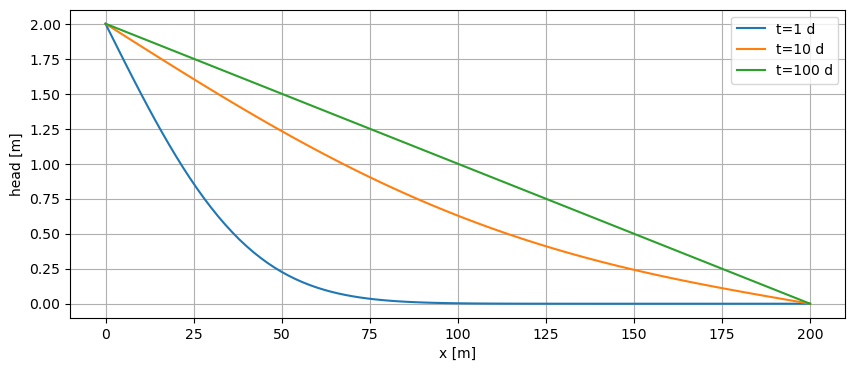

In [55]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    plt.plot(x, h.squeeze(), label=f"t={t[i]:.0f} d")

plt.legend()
plt.xlabel("x [m]")
plt.ylabel("head [m]")
plt.grid()

## Multi-layer

In [5]:
z = [0.0, -5.0, -6.0, -15.0]
Saq = [0.2, 1e-4]
c = [10.0]
k = [5.0, 10.0]
delh = 1.0
res = 10.0

In [56]:
mlconf = ttim.ModelMaq(
    kaq=k, z=z, Saq=Saq, c=c, tmin=1, tmax=1e2, topboundary="conf", phreatictop=True
)
hls_left = ttim.HeadLineSink1D(mlconf, xls=0.0, tsandh=[(0, delh)], layers=[0, 1])
hls_right = ttim.HeadLineSink1D(mlconf, xls=200.0, tsandh=[(0, 0.0)], layers=[0, 1])

hdiff = ttim.HeadDiffLineSink1D(mlconf, xls=100.0 + 1e-12, layers=[0, 1])
qdiff = ttim.FluxDiffLineSink1D(mlconf, xls=100.0 - 1e-12, layers=[0, 1])

mlconf.solve()

self.neq  8
solution complete


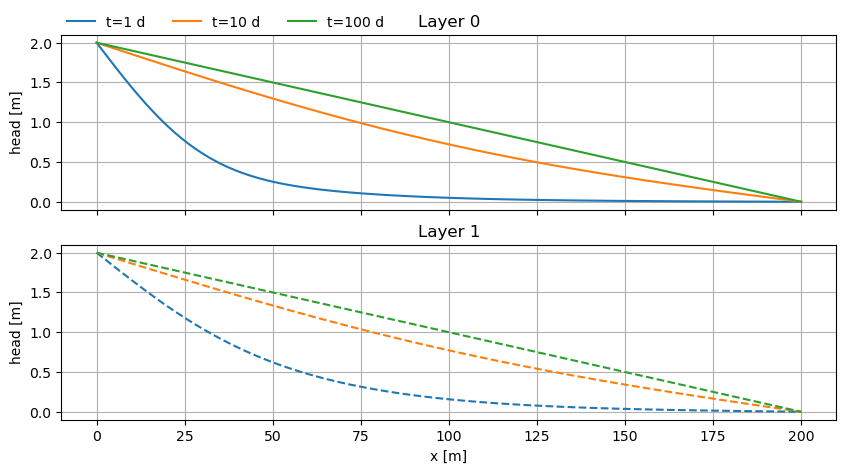

In [57]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 5))

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    ax0.plot(x, h[0].squeeze(), label=f"t={t[i]:.0f} d")
    ax1.plot(x, h[1].squeeze(), label=f"t={t[i]:.0f} d", ls="dashed")

ax0.legend(loc=(0, 1), frameon=False, ncol=3)
ax0.set_title("Layer 0")
ax1.set_xlabel("x [m]")
ax1.set_title("Layer 1")
for iax in [ax0, ax1]:
    iax.set_ylabel("head [m]")
    iax.grid()